In [1]:
import os
import sys
import pandas as pd
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import torch
import matplotlib.pyplot as plt
import AE_Stats
from load_data_fn import load_data,load_data_no_filter

from torch.autograd import Variable
from torch.utils.data import Dataset, DataLoader, TensorDataset
import importlib
import time

from losses import *
from telescope_torch import *

In [ ]:
# types = [ [1, 'both'],
#         [2, 'both'],
#         [3, 'both']]
types = [ [3, 'both']]
# types = [ [3, 'low'],
#           [3, 'high'],
#           [2,'low'],
#           [2,'high'],
#           [1,'low'],
#           [1,'high']]

loss = new_loss

for ty in types:
    print(ty)
    path = 'MIT_TTbar'
    prefixed = [filename for filename in os.listdir(path) if filename.startswith("dt_norm")]

    data = []
    for p in prefixed:
        data.append([torch.load(f'{path}/{p}'),p])
    path = '/uscms/home/nswood/nobackup/Notebooks/AE_Dev/models/batched_models/wafer_layer_split_mip_std_1_mean_nonzero'

    models = os.listdir(path)[9:]

    #all past 29
    cur_train = []
    
    for m in models:
        if int(m[8]) == ty[0]:
           
            if ty[1] == 'high':
                
                if int(m[10:]) >= 12:
                    cur_train.append(m)
            elif ty[1] == 'low':
                if int(m[10:]) < 12:
                    cur_train.append(m)
            else:
                cur_train.append(m)
    print(cur_train)
    #Calculating MSE of trained models
    path = '/uscms/home/nswood/nobackup/Notebooks/AE_Dev/models/batched_models/wafer_layer_split_mip_std_1_mean_nonzero'

    cur_model = models[1]

    def get_data(data,cur_model):
        cur_data = []
        for d in data:
            if d[1] == cur_model:
                cur_data = d[0]
                break
        return cur_data

    test_set = []
    train_set = []
    pred_set = []

    for m in cur_train:
        cur_model = torch.load(os.path.join(path,m)).to('cpu')
        cur_data = get_data(data,m).to('cpu')
        if len(cur_data)< 50000:
            train_set.append(cur_data[0:int(0.8*len(cur_data))])
            test_data = cur_data[-int(0.19*len(cur_data)):]
            test_set.append(test_data)
        else:
            train_set.append(cur_data[0:int(0.8*50000)])

            test_data = cur_data[-int(0.19*50000):]
            test_set.append(test_data)


    device = 'cuda'
    train_dt = torch.vstack(train_set).to(device)
    test_dt = torch.vstack(test_set).to(device)    
    mean = 0
    std = 1
    size_1_train =len(train_dt)
    size_1_test = len(test_dt)
    
    
    
    train_loc = train_dt
    test_loc = test_dt
    # train = torch.vstack([train,largest[0:1000]] )
    train_loc=train_loc[torch.randperm(train_loc.size()[0])]
    test_loc=test_loc[torch.randperm(test_loc.size()[0])]
    train_loc_d1_flat = DataLoader(
        TensorDataset(torch.Tensor(train_loc)),
        batch_size=100,
        shuffle=False
    )

    test_loc_d1_flat = DataLoader(
        TensorDataset(torch.Tensor(test_loc)),
        batch_size=100,
        shuffle=False
    )

    train_1 = train_dt[:,0:48]
    test_1 = test_dt[:,0:48]


    train_tc_sum = torch.unsqueeze(torch.sum(train_1[:,0:48],dim = 1),dim=1)
    test_tc_sum = torch.unsqueeze(torch.sum(test_1[:,0:48],dim = 1),dim=1)

    # train_1=train_1[torch.randperm(train_1.size()[0])]
    # test_1=test_1[torch.randperm(test_1.size()[0])]
    train_1 = train_1[torch.squeeze(train_tc_sum >3,dim=1)]
    test_1 = test_1[torch.squeeze(test_tc_sum >3,dim=1)]

    train_tc_sum = torch.unsqueeze(train_tc_sum[train_tc_sum >3],dim=1)
    test_tc_sum = torch.unsqueeze(test_tc_sum[test_tc_sum >3],dim=1)
#     train_1=train_1[torch.randperm(train_1.size()[0])]
#     test_1=test_1[torch.randperm(test_1.size()[0])]
    train_1_d1_flat = DataLoader(
        TensorDataset(torch.Tensor(train_1),train_tc_sum),
        batch_size=200,
        shuffle=False
    )

    test_1_d1_flat = DataLoader(
        TensorDataset(torch.Tensor(test_1),test_tc_sum),
        batch_size=200,
        shuffle=False
    )
    loss = new_loss
#     model_1 = CVAE_conv()
    
    model_1 = torch.load(f'models/CVAE_conv/dt_{ty[0]}_{ty[1]}_new_loss_greater_3')
    test = test_dt
    sum_TC_test = torch.unsqueeze(torch.sum(test_dt[:,0:48],dim=1),dim=1)
    
    lr = 2.25e-4
    num_epochs = 201

    optimizer = optim.Adam(model_1.parameters(), lr,weight_decay=5e-2)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor = 0.8)


    data_test = test
    # train
    running_loss = float("inf")
    for epoch in range(num_epochs):
        
        losses = []

        for i, (data,sum_TC) in enumerate(train_1_d1_flat):
            model_1.train()
            masked_dt = prepInput(data[:,0:48])
            v_pred = model_1(masked_dt,sum_TC)

            batch_loss = loss(torch.flatten(masked_dt,start_dim =1), torch.flatten(v_pred,start_dim =1),epoch,mean,std) #+ model_1.kl
            #batch_loss = telescopeMSE8x8(v_pred, masked_dt) + model_1.kl       

            losses.append(batch_loss.item()) 
            optimizer.zero_grad()
            batch_loss.backward()
            optimizer.step()

        scheduler.step(batch_loss)
        data_1_test = test[:,0:48]
        model_1.eval()

        test_pred = model_1(prepInput(data_1_test),sum_TC_test)
        batch_1_test =loss(torch.flatten(prepInput(data_1_test),start_dim =1), torch.flatten(test_pred,start_dim =1),epoch,mean,std) #+ model_1.kl
        #batch_1_test =telescopeMSE8x8(test_pred, prepInput(data_1_test)) +  model_1.kl
        running_loss = np.mean(losses)
        running_1est_loss = batch_1_test.item()

        print('Epoch {}, lr {}'.format(
            epoch, optimizer.param_groups[0]['lr']))

        print(f"Epoch {epoch}: Train {running_loss}, Test {running_1est_loss}")
    model_1.eval()
    # torch.save(model_1,'models/CVAE_conv/dt_1_144_16')

    
    torch.save(model_1,f'models/CVAE_conv/dt_{ty[0]}_{ty[1]}_new_loss_greater_3')
#     AE_Stats.gen_all_stats(test_pred.cpu(),data_1_test.cpu(),data_1_test.cpu())



[3, 'both']
['dt_norm_3_36', 'dt_norm_3_30', 'dt_norm_3_31', 'dt_norm_3_33', 'dt_norm_3_35', 'dt_norm_3_37', 'dt_norm_3_27', 'dt_norm_3_29', 'dt_norm_3_32', 'dt_norm_3_34', 'dt_norm_3_38', 'dt_norm_3_1', 'dt_norm_3_3', 'dt_norm_3_5', 'dt_norm_3_7', 'dt_norm_3_9', 'dt_norm_3_11', 'dt_norm_3_13', 'dt_norm_3_15', 'dt_norm_3_17', 'dt_norm_3_19', 'dt_norm_3_21', 'dt_norm_3_23', 'dt_norm_3_25', 'dt_norm_3_39', 'dt_norm_3_40', 'dt_norm_3_41', 'dt_norm_3_42', 'dt_norm_3_43', 'dt_norm_3_44', 'dt_norm_3_45', 'dt_norm_3_46', 'dt_norm_3_47']
Epoch 0, lr 0.000225
Epoch 0: Train 25.383422615039024, Test 23.031660079956055
Epoch 1, lr 0.000225
Epoch 1: Train 22.538729850777937, Test 23.02463722229004
Epoch 2, lr 0.000225
Epoch 2: Train 23.960784940595147, Test 22.746641159057617
Epoch 3, lr 0.000225
Epoch 3: Train 22.413830992165817, Test 22.015972137451172
Epoch 4, lr 0.000225
Epoch 4: Train 22.641961239902425, Test 21.72266387939453
Epoch 5, lr 0.000225
Epoch 5: Train 21.745451975838193, Test 20.50

MSE 4.22213077545166
Median 0.537015974521637
Standard Devitaion 32.06544876098633
Average std error 3.241356372833252
Average % Error of Energy Reconstruction nan


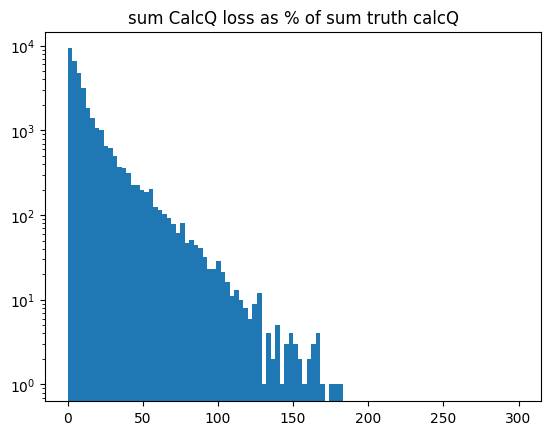

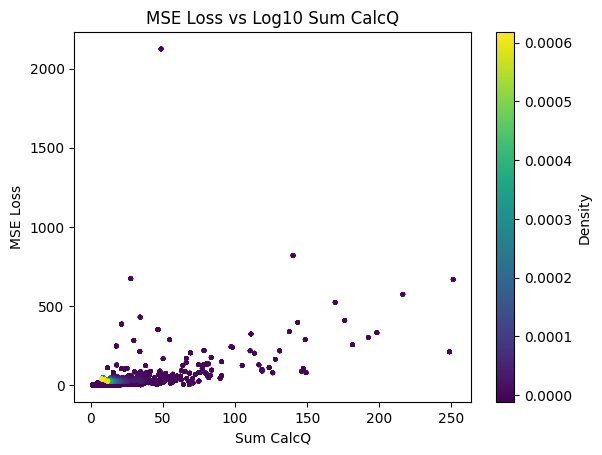

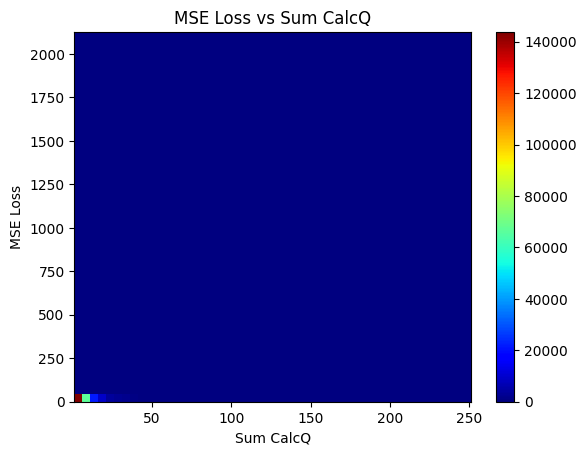

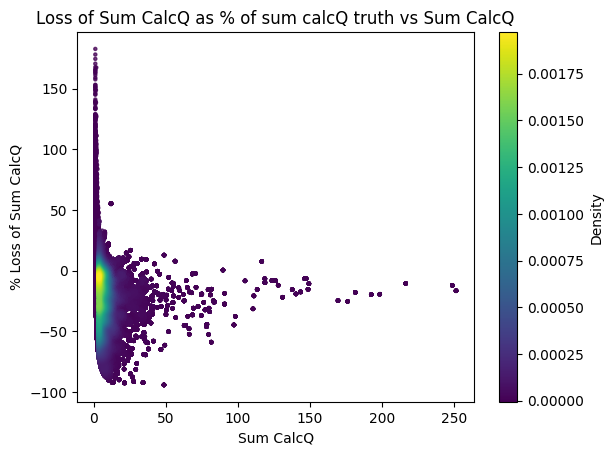

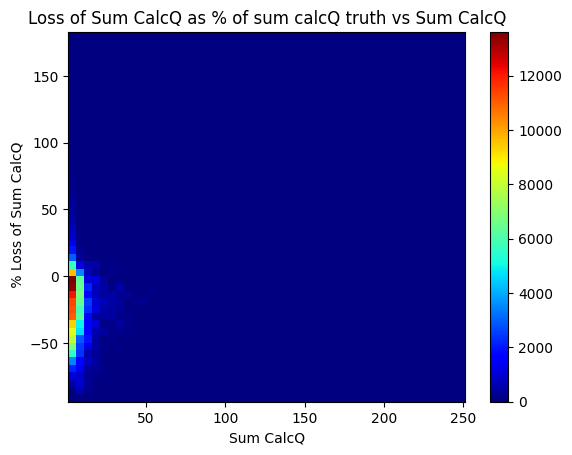

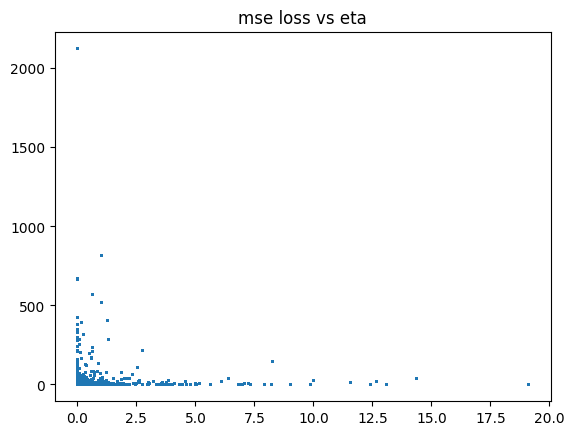

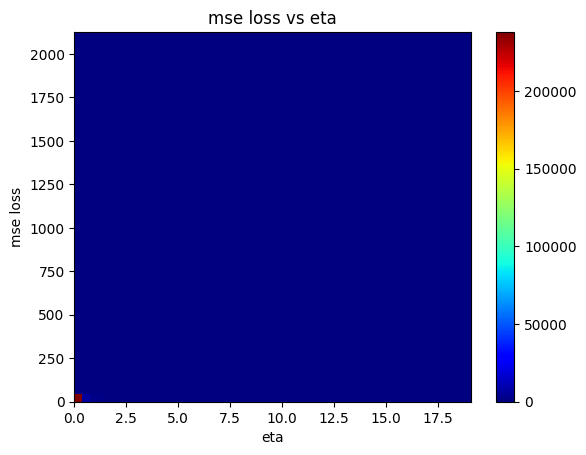

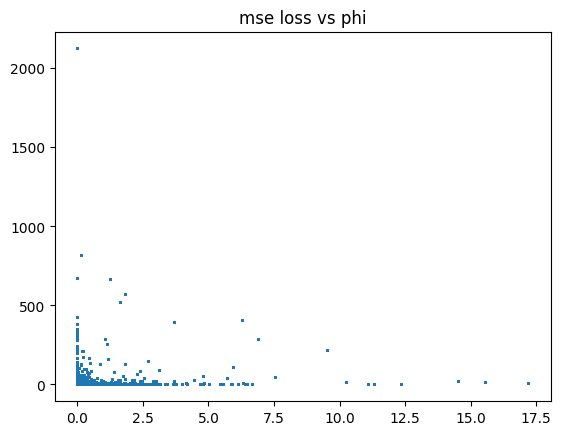

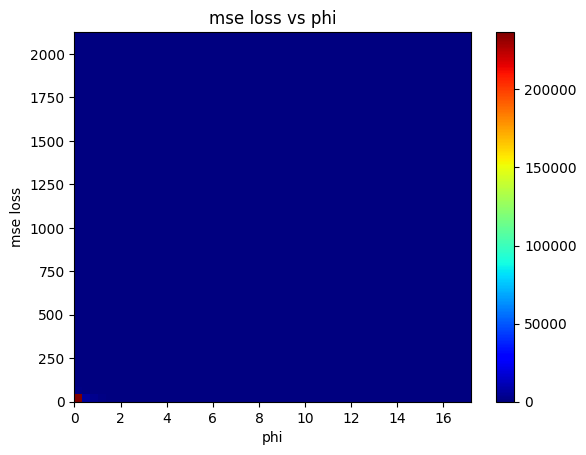

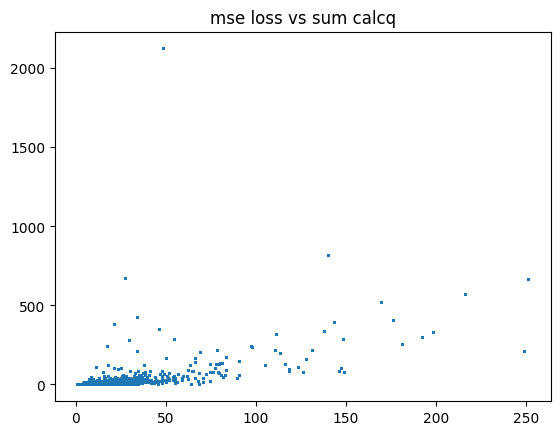

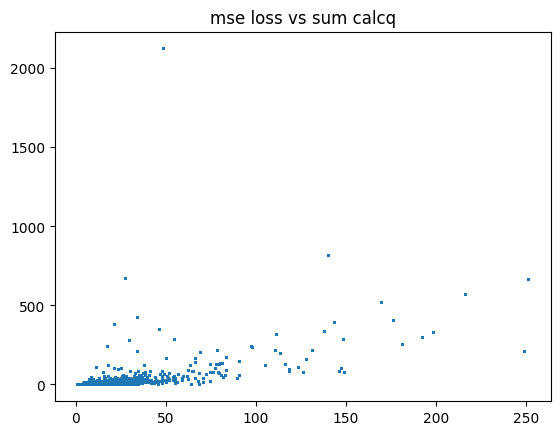

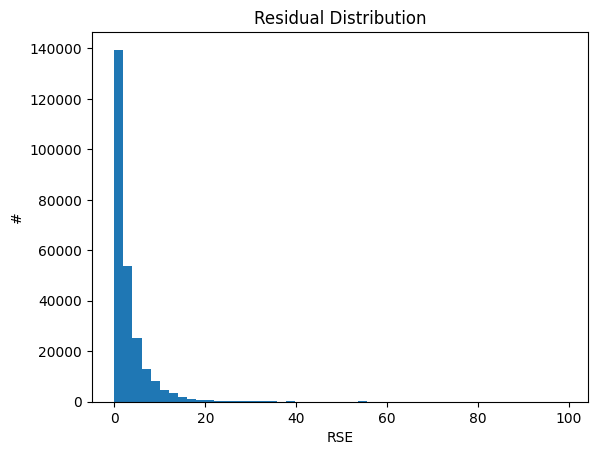

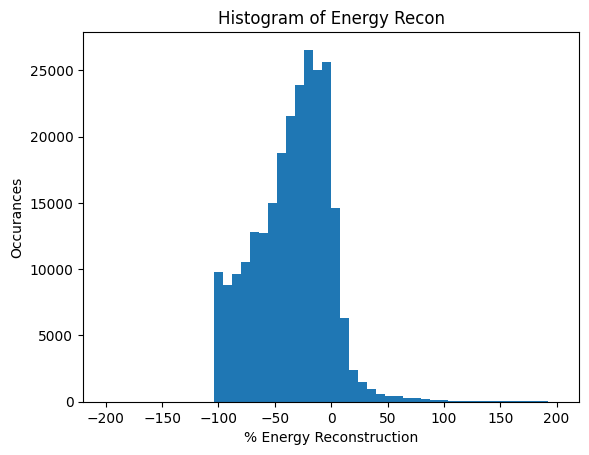

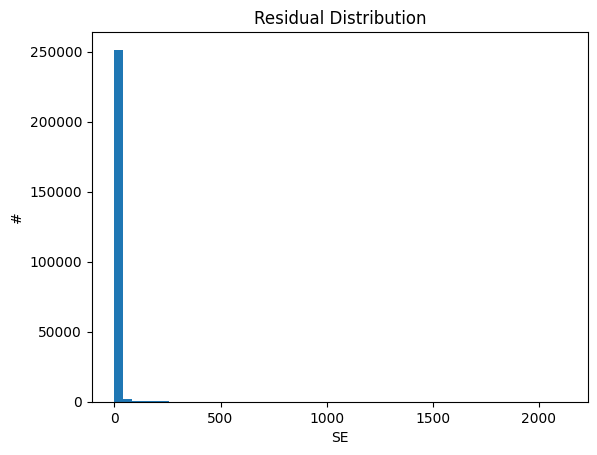

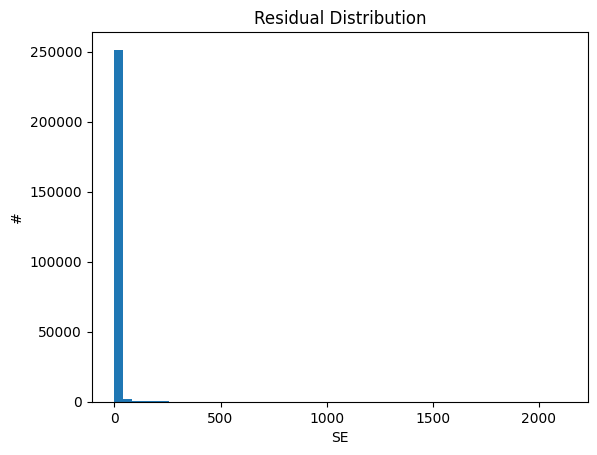

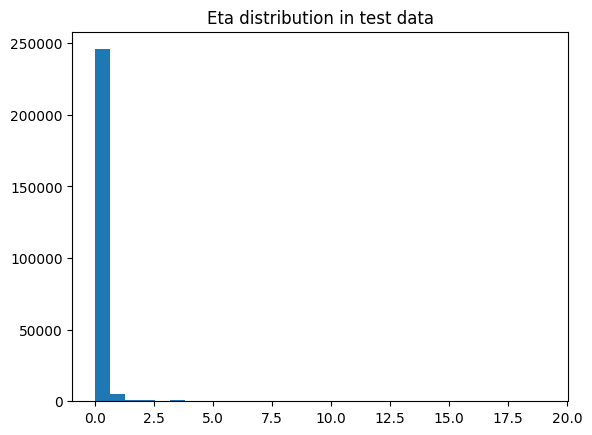

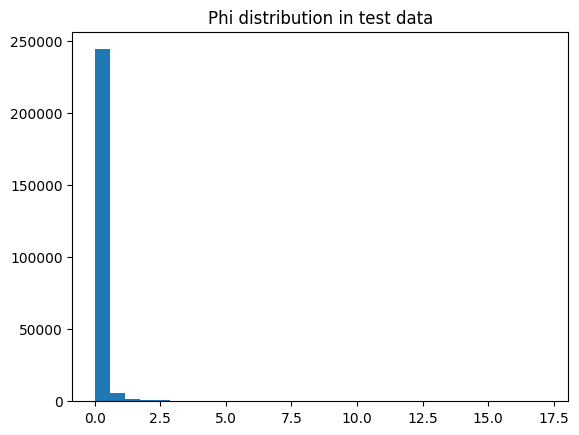

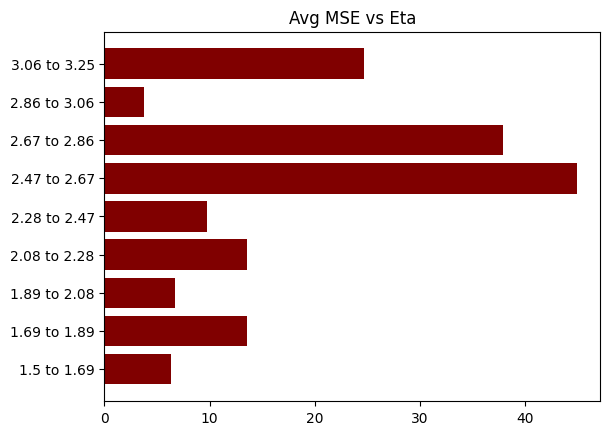

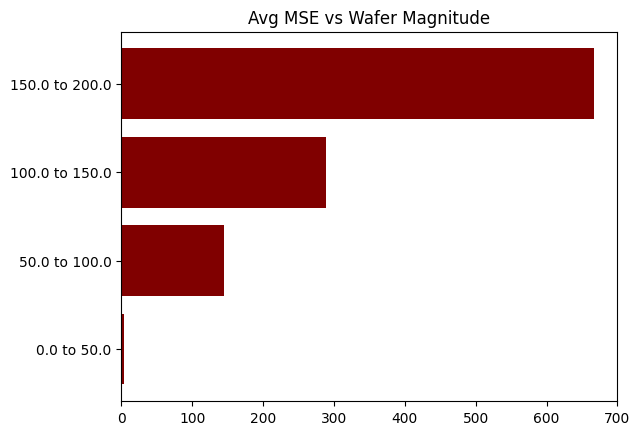

tensor([[0.0000, 0.0000, 3.3436, 0.8050, 2.4324],
        [0.7418, 0.0509, 1.8206, 0.0544, 0.3212],
        [0.1929, 0.1670, 6.7737, 1.1026, 3.7682],
        ...,
        [0.0000, 0.0000, 1.8589, 0.6703, 0.8589],
        [0.0000, 0.0000, 1.4998, 0.1372, 0.4998],
        [0.0000, 0.0000, 1.4188, 0.0722, 0.5634]], grad_fn=<CatBackward0>)

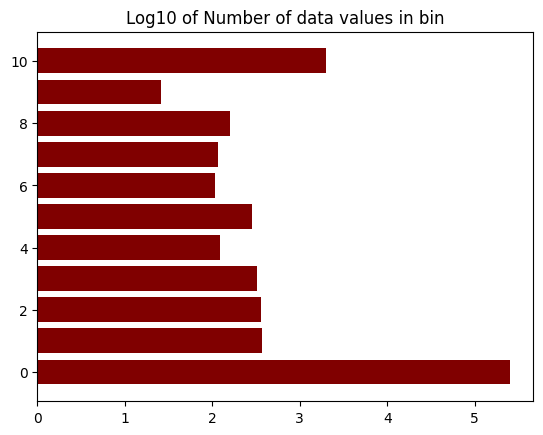

In [24]:
AE_Stats.gen_all_stats(torch.flatten(test_pred.cpu(),start_dim =1),torch.flatten(prepInput(data_1_test.cpu()),start_dim = 1),data_1_test.cpu())


# Diving by total MIP and passing MIP as latent Variable

In [7]:
path = 'MIT_TTbar'
prefixed = [filename for filename in os.listdir(path) if filename.startswith("dt_norm")]

data = []
for p in prefixed:
    data.append([torch.load(f'{path}/{p}'),p])
path = '/uscms/home/nswood/nobackup/Notebooks/AE_Dev/models/batched_models/wafer_layer_split_mip_std_1_mean_nonzero'

models = os.listdir(path)[9:]

#all past 29
cur_train = []
for m in models:
    if int(m[8]) == 1:
        cur_train.append(m)
#Calculating MSE of trained models
path = '/uscms/home/nswood/nobackup/Notebooks/AE_Dev/models/batched_models/wafer_layer_split_mip_std_1_mean_nonzero'

cur_model = models[1]

def get_data(data,cur_model):
    cur_data = []
    for d in data:
        if d[1] == cur_model:
            cur_data = d[0]
            break
    return cur_data

test_set = []
train_set = []
pred_set = []

for m in cur_train:
    cur_model = torch.load(os.path.join(path,m)).to('cpu')
    cur_data = get_data(data,m).to('cpu')
    if len(cur_data)< 100000:
        train_set.append(cur_data[0:int(0.8*len(cur_data))])
        test_data = cur_data[-int(0.19*len(cur_data)):]
        test_set.append(test_data)
    else:
        train_set.append(cur_data[0:int(0.8*10000)])

        test_data = cur_data[-int(0.19*100000):100000]
        test_set.append(test_data)
    
    
device = 'cuda'
train_dt = torch.vstack(train_set).to(device)
test_dt = torch.vstack(test_set).to(device)    
mean = 0
std = 1
size_1_train =len(train_dt)
size_1_test = len(test_dt)
train_loc = train_dt
test_loc = test_dt
# train = torch.vstack([train,largest[0:1000]] )
train_loc=train_loc[torch.randperm(train_loc.size()[0])]
test_loc=test_loc[torch.randperm(test_loc.size()[0])]
train_loc_d1_flat = DataLoader(
    TensorDataset(torch.Tensor(train_loc)),
    batch_size=100,
    shuffle=False
)

test_loc_d1_flat = DataLoader(
    TensorDataset(torch.Tensor(test_loc)),
    batch_size=100,
    shuffle=False
)


train_1 = train_dt[:,0:48]
test_1 = test_dt[:,0:48]

train_tc_sum = torch.unsqueeze(torch.sum(train_1[:,0:48],dim = 1),dim=1)
test_tc_sum = torch.unsqueeze(torch.sum(test_1[:,0:48],dim = 1),dim=1)

# train_1=train_1[torch.randperm(train_1.size()[0])]
# test_1=test_1[torch.randperm(test_1.size()[0])]
train_1 = train_1[torch.squeeze(train_tc_sum !=0,dim=1)]
test_1 = test_1[torch.squeeze(test_tc_sum !=0,dim=1)]

train_tc_sum = torch.unsqueeze(train_tc_sum[train_tc_sum !=0],dim=1)
test_tc_sum = torch.unsqueeze(test_tc_sum[test_tc_sum != 0],dim=1)

train_1_d1_flat = DataLoader(
    TensorDataset(torch.Tensor(torch.squeeze(train_1/train_tc_sum,dim=0)),torch.squeeze(train_tc_sum,dim=0)),
    batch_size=100,
    shuffle=False
)

test_1_d1_flat = DataLoader(
    TensorDataset(torch.Tensor(torch.squeeze(test_1/test_tc_sum,dim=0)),torch.squeeze(test_tc_sum,dim=0)),
    batch_size=100,
    shuffle=False
)


In [281]:
test = torch.Tensor(torch.squeeze(test_1/test_tc_sum,dim=0))
sum_TC_test = torch.unsqueeze(torch.sum(test_dt[:,0:48],dim=1),dim=1)


In [16]:
loss = new_loss
# model_1 =CVAE_conv()

test = torch.Tensor(torch.squeeze(test_1/test_tc_sum,dim=0))
sum_TC_test = torch.unsqueeze(torch.sum(test_dt[:,0:48],dim=1),dim=1)
sum_TC_test = torch.unsqueeze(sum_TC_test[sum_TC_test != 0],dim=1)

lr = 3.25e-5
num_epochs = 101

optimizer = optim.Adam(model_1.parameters(), lr,weight_decay=5e-2)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min',factor = 0.8)


data_test = test
# train
running_loss = float("inf")
for epoch in range(num_epochs):

    losses = []
    
    for i, (data,sum_TC) in enumerate(train_1_d1_flat):
        model_1.train()
        masked_dt = prepInput(data[:,0:48])
        v_pred = model_1(masked_dt,sum_TC)
        
#         batch_loss = loss(torch.flatten(masked_dt,start_dim =1), torch.flatten(v_pred,start_dim =1),epoch,mean,std) #+ model_1.kl
        batch_loss = telescopeMSE8x8(v_pred, torch.tensor(masked_dt)) #+ model_1.kl       
       
        losses.append(batch_loss.item()) 
        optimizer.zero_grad()
        batch_loss.backward()
        optimizer.step()
        
    scheduler.step(batch_loss)
    data_1_test = test
    model_1.eval()
    
    test_pred = model_1(prepInput(data_1_test),sum_TC_test)
#     batch_1_test =loss(torch.flatten(prepInput(data_1_test),start_dim =1), torch.flatten(test_pred,start_dim =1),epoch,mean,std) #+ model_1.kl
    batch_1_test =telescopeMSE8x8(test_pred, torch.tensor(prepInput(data_1_test))) #+  model_1.kl
    running_loss = np.mean(losses)
    running_1est_loss = batch_1_test.item()
    
    print('Epoch {}, lr {}'.format(
        epoch, optimizer.param_groups[0]['lr']))
    
    print(f"Epoch {epoch}: Train {running_loss}, Test {running_1est_loss}")
model_1.eval()
# torch.save(model_1,'models/CVAE_conv/dt_1_144_16')

# AE_Stats.gen_all_stats(model_1(dt_1[-size_1_test:,0:48]).cpu(),dt_1[-size_1_test:,0:48].cpu(),dt_1[-size_1_test:].cpu())

/tmp/ipykernel_64716/1316587537.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_loss = telescopeMSE8x8(v_pred, torch.tensor(masked_dt)) #+ model_1.kl
/tmp/ipykernel_64716/1316587537.py:41: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  batch_1_test =telescopeMSE8x8(test_pred, torch.tensor(prepInput(data_1_test))) #+  model_1.kl


Epoch 0, lr 3.25e-05
Epoch 0: Train 0.0316418911427668, Test 0.032222311943769455
Epoch 1, lr 3.25e-05
Epoch 1: Train 0.031673053178119207, Test 0.032161880284547806
Epoch 2, lr 3.25e-05
Epoch 2: Train 0.03164586190781106, Test 0.032170284539461136
Epoch 3, lr 3.25e-05
Epoch 3: Train 0.031637893327057125, Test 0.03215055540204048
Epoch 4, lr 3.25e-05
Epoch 4: Train 0.03164581721551308, Test 0.032155975699424744
Epoch 5, lr 3.25e-05
Epoch 5: Train 0.03163866456184663, Test 0.03218216076493263
Epoch 6, lr 3.25e-05
Epoch 6: Train 0.031636991200837315, Test 0.03219551220536232
Epoch 7, lr 3.25e-05
Epoch 7: Train 0.03163584591383139, Test 0.032203808426856995
Epoch 8, lr 3.25e-05
Epoch 8: Train 0.031637069228161174, Test 0.03219950571656227
Epoch 9, lr 3.25e-05
Epoch 9: Train 0.031642007975481626, Test 0.03217019885778427
Epoch 10, lr 3.25e-05
Epoch 10: Train 0.03164184418198101, Test 0.03219118341803551
Epoch 11, lr 3.25e-05
Epoch 11: Train 0.03164174586957608, Test 0.03218257799744606


KeyboardInterrupt: 

MSE 3.595082998275757
Median 1.5159279108047485
Standard Devitaion 6.270270347595215
Average std error 7.4461669921875
Average % Error of Energy Reconstruction nan


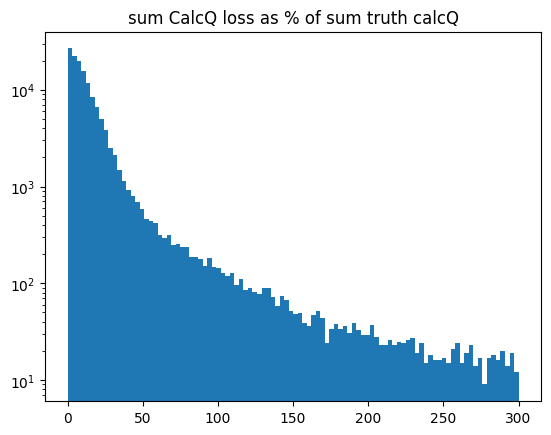

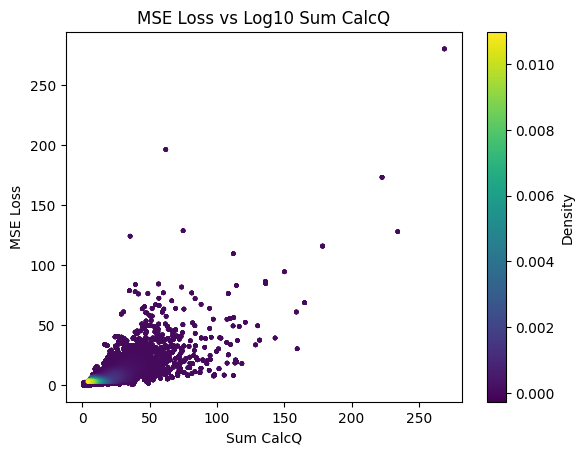

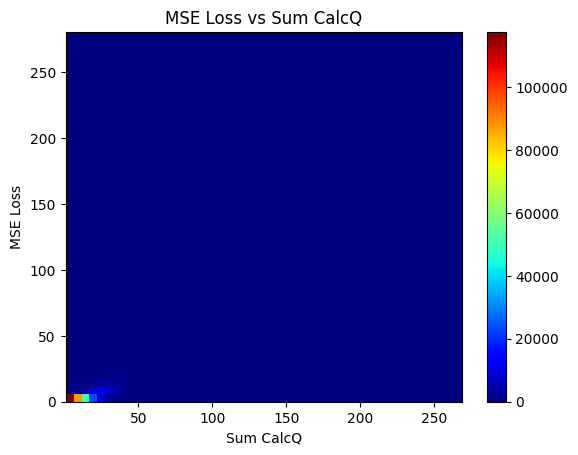

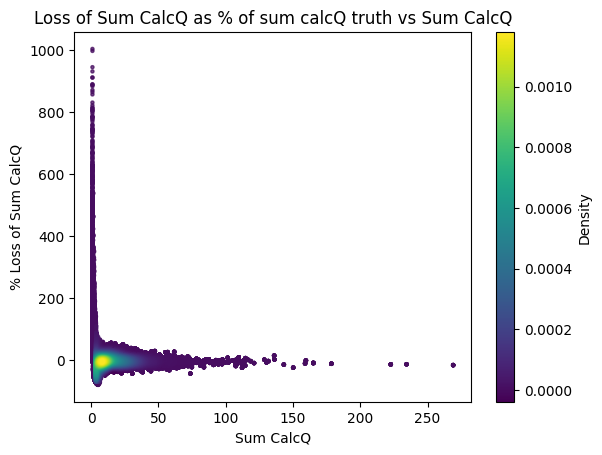

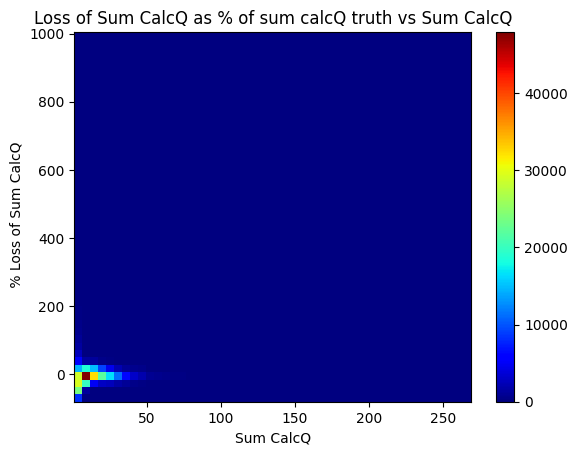

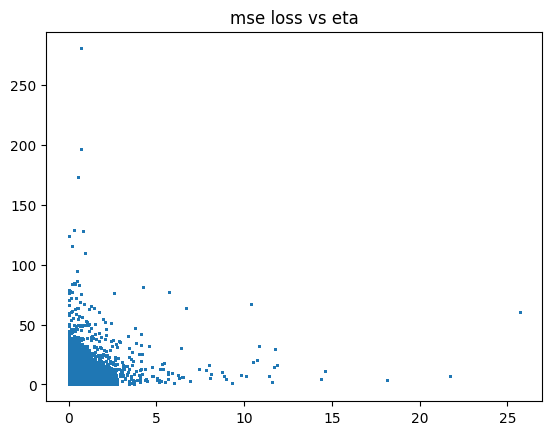

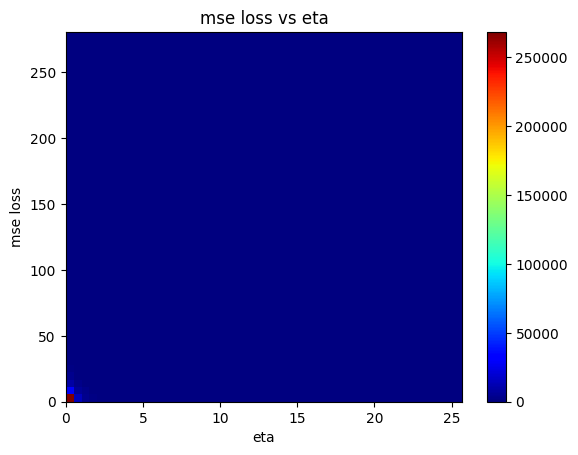

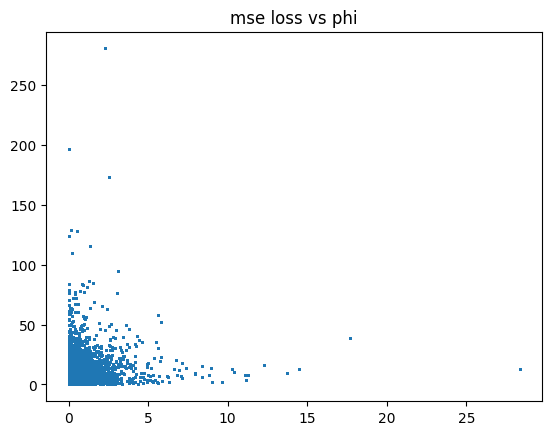

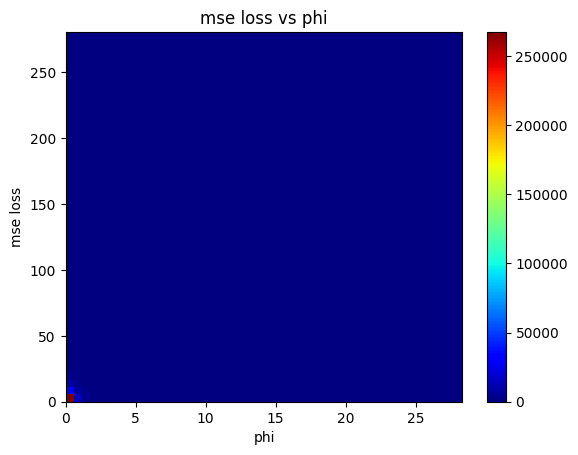

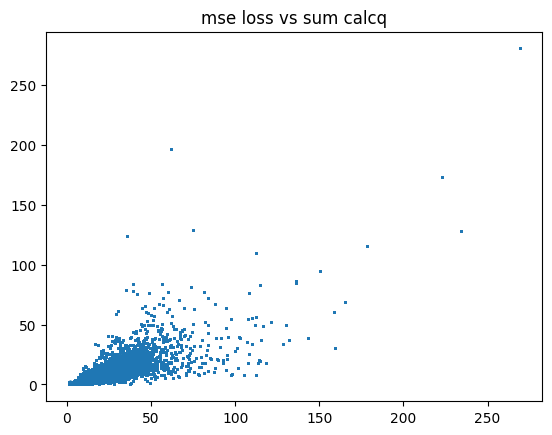

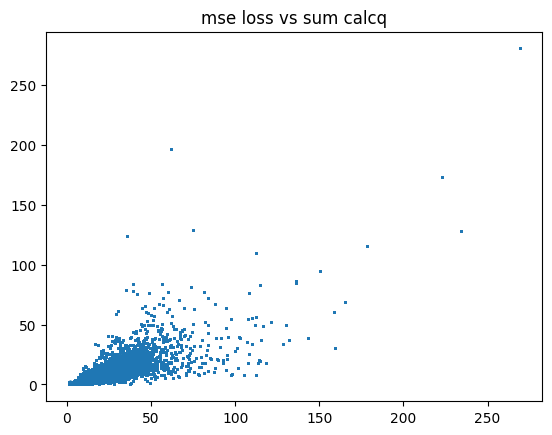

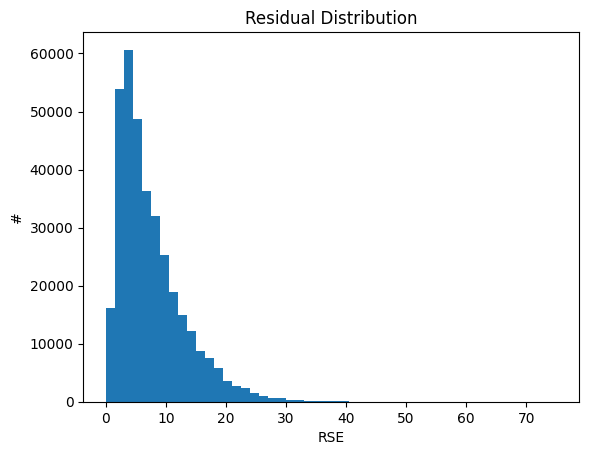

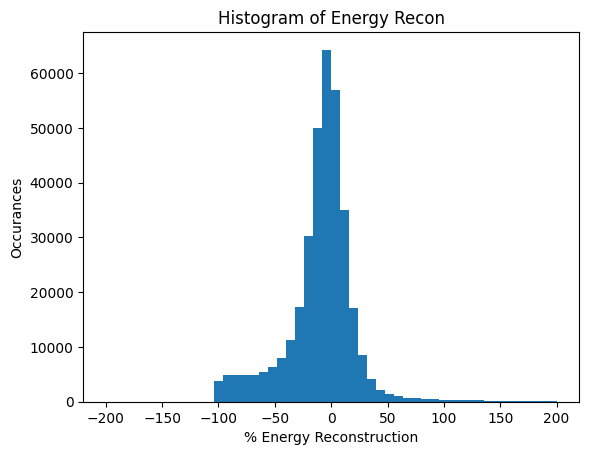

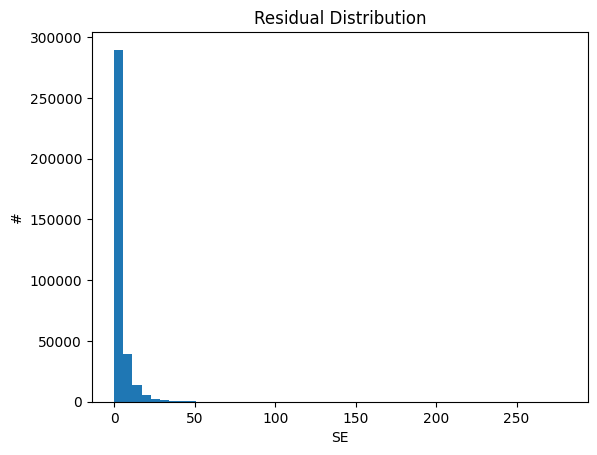

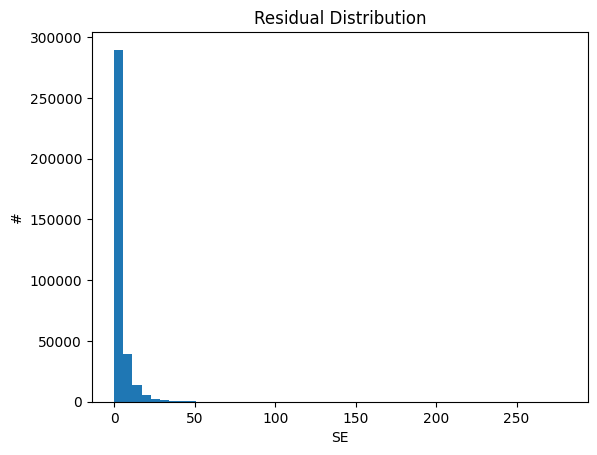

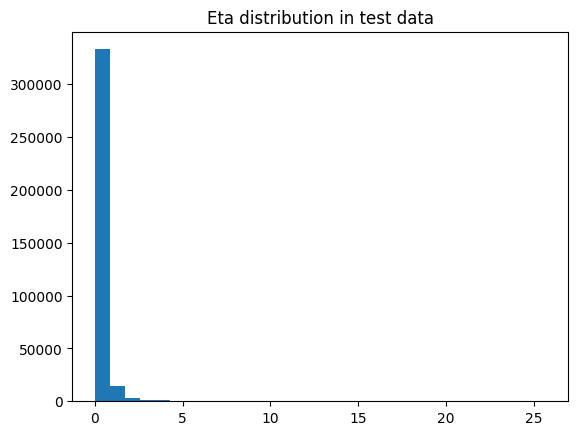

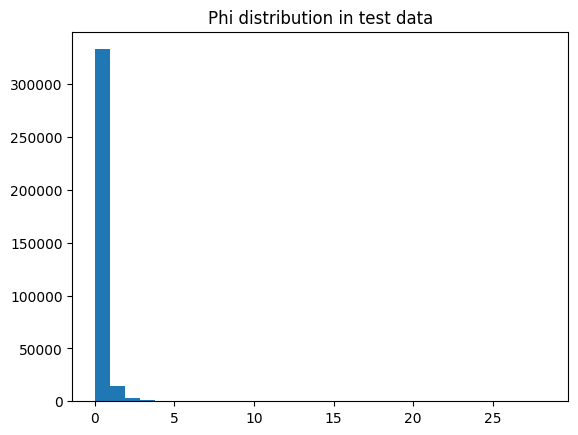

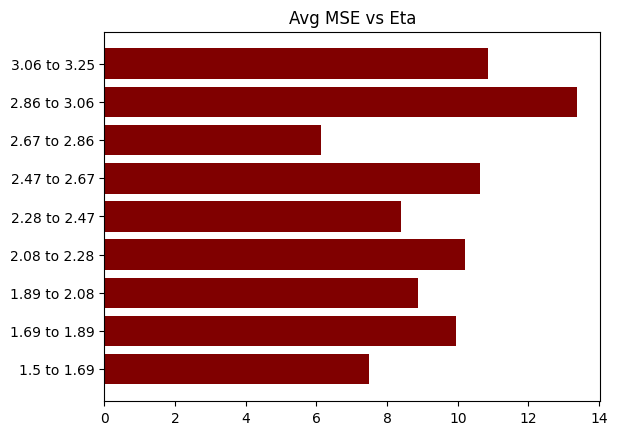

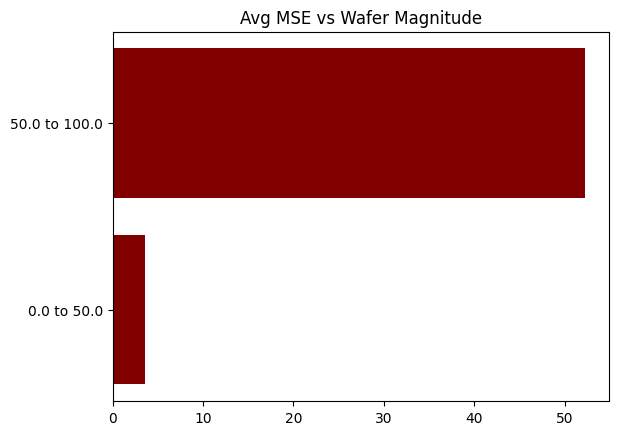

tensor([[ 0.0000,  0.0000, 20.7637,  3.4915, 10.4514],
        [ 0.0000,  0.0000, 24.1467,  1.6112,  6.1332],
        [ 0.0000,  0.0000, 18.2314,  3.0657,  9.7324],
        ...,
        [ 0.0000,  0.0000,  5.0688,  1.1475,  4.9425],
        [ 0.0379,  0.0000,  5.7203,  0.7452,  3.5438],
        [ 0.0000,  0.0000,  8.6337,  0.1602,  1.1081]], grad_fn=<CatBackward0>)

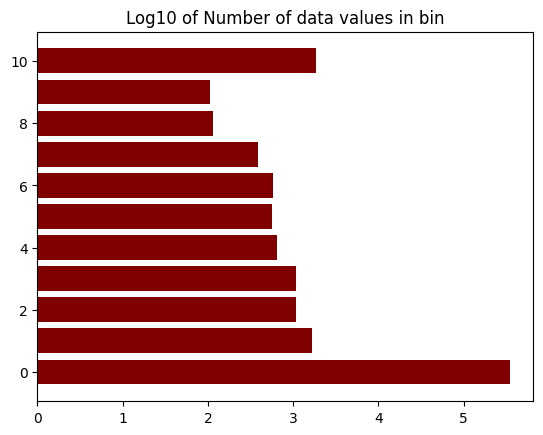

In [153]:
AE_Stats.gen_all_stats(torch.flatten(test_pred.cpu(),start_dim =1),torch.flatten(prepInput(data_1_test.cpu()),start_dim = 1),data_1_test.cpu())
 


In [ ]:
from plotWafer import plotWafer

In [11]:
def telescopeMSE8x8(y_true,y_pred):
    return telescopeMSE2(torch.matmul(torch.reshape(y_true,(-1,64)),torch.tensor(remap_8x8_matrix).to(device)),
                         torch.matmul(torch.reshape(y_pred,(-1,64)),torch.tensor(remap_8x8_matrix).to(device)))

In [12]:
telescopeMSE8x8(prepInput(data_1_test),test_pred)

NameError: name 'data_1_test' is not defined

In [2]:
class CVAE_conv(nn.Module):

    def __init__(self,latent_dims = 16, with_loc=False,device = 'cuda'):
        """Initialize the DAE

        Parameters
        ----------
        layers: list[int]
            the number of dimensions in each layer of the DAE

        """
        
        super(CVAE_conv, self).__init__()
        
        
        #Encoders pre conditioning
        self.encoders = nn.Sequential(nn.Linear(128,16),
                                     nn.ReLU()).to(device)
        self.decoders = nn.Sequential(nn.Linear(17,128),
                                     nn.ReLU()).to(device)
        self.unflatten = nn.Unflatten(dim=1, unflattened_size=(8,4,4)).to(device)
        self.device = device
        
        #post conditioning
        self.linear_enc = nn.Linear(17,16).to(device)
        self.linear_mean = nn.Linear(16,latent_dims).to(device)
        self.linear_sig = nn.Linear(16,latent_dims).to(device)
        
        self.final_decoder = nn.Sequential(nn.Linear(72,48)).to(device)
        
        self.N       = torch.distributions.Normal(0, 1)
        self.N.loc   = self.N.loc 
        self.N.scale = self.N.scale
        self.kl = 0
        
        self.conv1 = nn.Conv2d(1, 8, 2,stride = 2).to(device)
        self.decoder_conv = nn.ConvTranspose2d(8, 1, 2,stride = 2).to(device)
        
    def forward(self, x,c):
        """Forward step
        
        Parameters
        ----------
        x: Tensor
            input tensor
        
        Returns
        -------
        Tensor
            a reconstructed version of x

        """
        x_encoded = self.encode(x,c)
        x_reconstructed = self.decode(x_encoded,c)
        return x_reconstructed

    def encode(self, x,c):
        """Encode the input x
        
        Parameters
        ----------
        x: Tensor
            input to encode
        x: Tensor
            conditional data
        
        Returns
        -------
        Tensor
            encoded input

        """
        x = F.relu(self.conv1(x))
        x = torch.flatten(x, start_dim=1)
        
        for i, enc in enumerate(self.encoders):
            if i == len(self.encoders) - 1:
                x = enc(x)
            else:
                x = enc(x)
        x = torch.hstack((x,c))
        x = F.relu(self.linear_enc(x))
        
        mu =  self.linear_mean(x) #Mean in the gaussian space
        sigma = torch.exp(self.linear_sig(x)).to(device) #sigma in the space
        z = mu + sigma*self.N.sample(mu.shape).to(device) #smear 
        self.kl = torch.sum((sigma**2 + mu**2 - torch.log(sigma) - 1/2),dim=1).mean()
        return z
    
    def decode(self, x,c):
        """Decode the representation x
        
        Parameters
        ----------
        x: Tensor
            input to decode
        
        Returns
        -------
        Tensor
            decoded input

        """
        x = torch.hstack((x,c))
        
        for dec in self.decoders:
            x = dec(x)
        
        
        
        x = self.unflatten(x)
        
        x =F.relu(self.decoder_conv(x))
        
        
        return x

In [3]:
model = CVAE_conv()

In [4]:
model.conv1(prepInput(train_1)).shape

NameError: name 'prepInput' is not defined

In [130]:
prepInput(train_1).shape

torch.Size([49701, 1, 8, 8])

In [131]:
latent = model.encode(prepInput(train_1),tc_sum)

In [132]:
x = torch.hstack((latent,tc_sum))

In [133]:
model.decoder_conv(model.unflatten(model.decoders(x))).shape

torch.Size([49701, 1, 8, 8])

In [137]:
model(prepInput(train_1),tc_sum).shape

torch.Size([49701, 128])


torch.Size([49701, 1, 8, 8])

# Rohan's Solution
Zero padding wafer to allow for convolution if possible

https://github.com/rohanshenoy/Ecoder/blob/main/econ_autoencoder.ipynb


In [5]:
arrange =  np.array([28,29,30,31,0,4,8,12,
                     24,25,26,27,1,5,9,13,
                     20,21,22,23,2,6,10,14,
                     16,17,18,19,3,7,11,15,
                     47,43,39,35,35,34,33,32,
                     46,42,38,34,39,38,37,36,
                     45,41,37,33,43,42,41,40,
                     44,40,36,32,47,46,45,44])

arrMask= np.array([1,1,1,1,1,1,1,1,
                   1,1,1,1,1,1,1,1,
                   1,1,1,1,1,1,1,1,
                   1,1,1,1,1,1,1,1,
                   1,1,1,1,0,0,0,0,
                   1,1,1,1,0,0,0,0,
                   1,1,1,1,0,0,0,0,
                   1,1,1,1,0,0,0,0,])
    
calQMask=np.array([1,1,1,1,1,1,1,1,
                    1,1,1,1,1,1,1,1,
                    1,1,1,1,1,1,1,1,
                    1,1,1,1,1,1,1,1,
                    1,1,1,1,0,0,0,0,
                    1,1,1,1,0,0,0,0,
                    1,1,1,1,0,0,0,0,
                    1,1,1,1,0,0,0,0,])

In [6]:
def prepInput(normData):
    
    shape = (1,8,8)
    inputdata = normData[:,arrange]

    inputdata[:,arrMask==0]=0  #zeros out repeated entries

    shaped_data = inputdata.reshape(len(inputdata),shape[0],shape[1],shape[2])
    
    return shaped_data
